In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from math import *
%run functions.ipynb

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.
Welcome to JupyROOT 6.14/06


In [2]:
def getJet(inputFiles):
    
    cols = []
    scalar = []
    
    scalar.append('event')
    scalar.append('njets')
    scalar.append('electron_truthPhi')
    scalar.append('electron_truthPt')
    scalar.append('electron_truthEta')
    
    cols.append('matched_truthNComponent')
    cols.append('pt')
    cols.append('eta')
    cols.append('phi')
    
    lists = scalar+cols
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists, flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [3]:
def getElectron(inputFiles):
    
    scalar = []
    
    scalar.append('event')
    scalar.append('njets')
    scalar.append('electron_truthPhi')
    scalar.append('electron_truthPt')
    scalar.append('electron_truthEta')
    
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=scalar)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [4]:
file1 = ["$HOME/EIC/output/allsi/710.root"]

In [5]:
aj = getJet(file1)
ae = getElectron(file1)


Processed $HOME/EIC/output/allsi/710.root in 69.7 seconds

Processed $HOME/EIC/output/allsi/710.root in 10.0 seconds


In [7]:
eq1 = "electron_truthP = electron_truthPt * cosh(electron_truthEta)"
eq2 = "p = pt * cosh(eta)"
eq3 = "Q2 = 40 * sqrt(electron_truthP**2 + 2.61119927e-7) * (1 - tanh(electron_truthEta))"
eq4 = "theta = 2 * arctan( exp(- electron_truthEta))" # electron theta
eq5 = "theta_neg = 6.28318530718 - 2 * arctan( exp(- eta))" # jet theta

In [8]:
ae.eval(eq1, inplace = True)
ae.eval(eq3, inplace = True)
ae.eval(eq4, inplace = True)
aj.eval(eq1, inplace = True)
aj.eval(eq2, inplace = True)
aj.eval(eq3, inplace = True)
aj.eval(eq5, inplace = True)

In [9]:
ae0 = applyCut(ae, 'Q2 > 16', 'Q2 > 16')

Q2 > 16 3875058  fraction kept: 99.8


In [10]:
aj.eval('dphi = phi - electron_truthPhi - 3.1415926535', inplace=True)
aj0 = fix_dphi(aj)
aj0 = applyCut(aj0, 'Q2 > 16', 'Q2 > 16')
aj0_dphi = applyCut(aj0, 'abs_dphi < 0.4', 'abs_dphi < 0.4 with fakes')
aj_array = partitionEta(aj0, np.arange(-0.1, 13.1, 1), 'njets')

Fixed dphi delta phi range
Q2 > 16 9178300  fraction kept: 99.7
abs_dphi < 0.4 with fakes 3552193  fraction kept: 38.7
-0.1 < njets < 0.9 0  fraction kept: 0.0
0.9 < njets < 1.9 1054938  fraction kept: 11.5
1.9 < njets < 2.9 2580486  fraction kept: 28.1
2.9 < njets < 3.9 2637942  fraction kept: 28.7
3.9 < njets < 4.9 1708740  fraction kept: 18.6
4.9 < njets < 5.9 805245  fraction kept: 8.8
5.9 < njets < 6.9 289860  fraction kept: 3.2
6.9 < njets < 7.9 80213  fraction kept: 0.9
7.9 < njets < 8.9 17664  fraction kept: 0.2
8.9 < njets < 9.9 2826  fraction kept: 0.0
9.9 < njets < 10.9 330  fraction kept: 0.0
10.9 < njets < 11.9 44  fraction kept: 0.0
11.9 < njets < 12.9 12  fraction kept: 0.0


In [11]:
radii = [0, 10, 20, 30, 40]
r_labels = ['$0$','$10$','$20$','$30$','$40$']
radii_s = [0, 5, 10, 15, 20]
r_labels_s = ['$0$','$5$','$10$','$15$','$20$']
angles = [90, 139.604937421, 164.585373193, 174.299529125, 177.90141703, 180, 182.09858297, 185.700470875, 195.414626807,
          220.395062579, 270, 319.604937421, 344.585373193, 354.299529125, 357.90141703, 360]
eta_labels=['0','-1','-2','-3','','','','-3','-2','-1','0','1','2','3','']
nr = 40
nr_s = 20
ntheta = 90

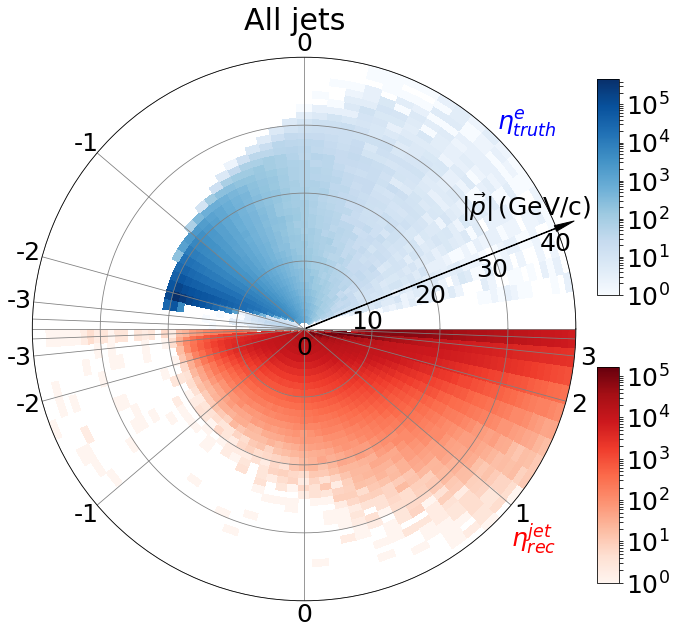

In [12]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['theta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj0['p'], aj0['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('All jets',fontsize=30, y=0.95)
fig.savefig('images/polar0.pdf', bbox_inches='tight')

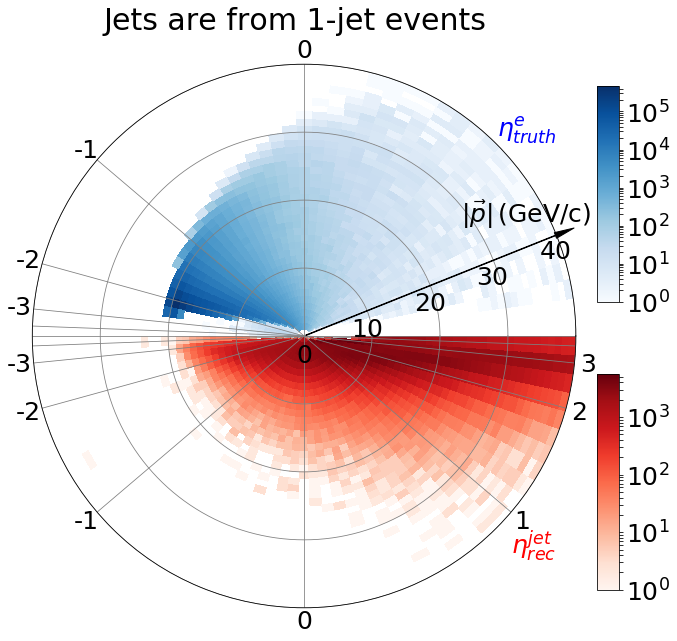

In [13]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['theta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj_array[1]['p'], aj_array[1]['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('Jets are from 1-jet events',fontsize=30,y=0.96)
fig.savefig('images/polar1.pdf', bbox_inches='tight')

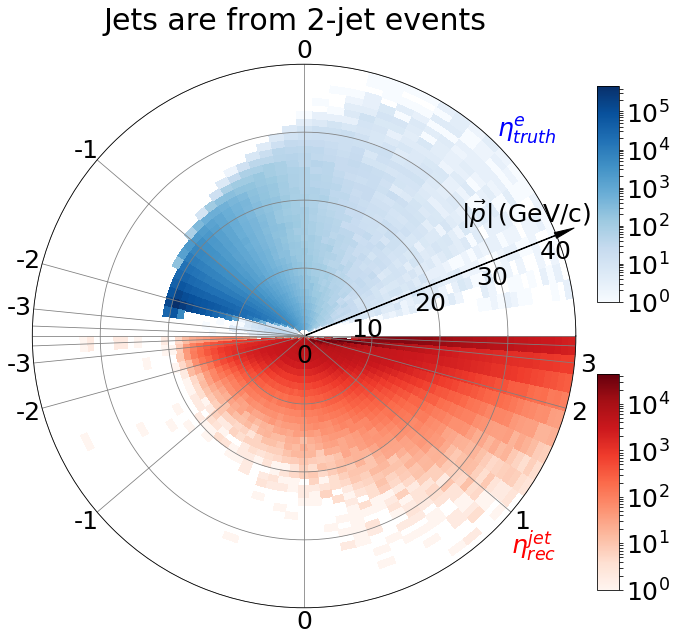

In [14]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['theta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj_array[2]['p'], aj_array[2]['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('Jets are from 2-jet events',fontsize=30,y=0.96)
fig.savefig('images/polar2.pdf', bbox_inches='tight')

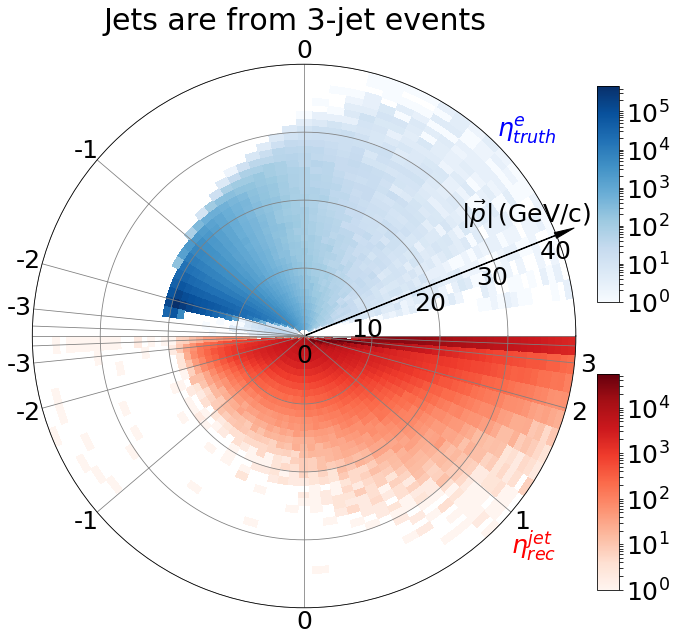

In [15]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['theta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj_array[3]['p'], aj_array[3]['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('Jets are from 3-jet events',fontsize=30,y=0.96)
fig.savefig('images/polar3.pdf', bbox_inches='tight')

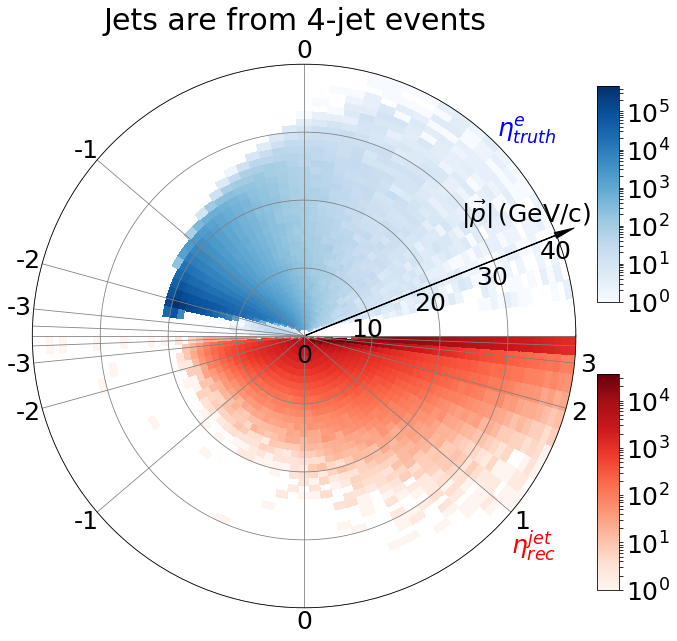

In [16]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['theta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj_array[4]['p'], aj_array[4]['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('Jets are from 4-jet events',fontsize=30,y=0.96)
fig.savefig('images/polar4.pdf', bbox_inches='tight')

In [17]:
def count_njet(df):
    max_njet = max(df['njets'])
    njets_passed_array = []
    jet_index = 0
    while (jet_index < len(df)):
        event_index = np.asarray(df['event'])[jet_index]
        njet = 1
        end_index = jet_index + max_njet - 1
        if end_index >= len(df) - 1:
            end_index = len(df) - 1
        for j in range(jet_index + 1, end_index + 1):
            event_index2 = np.asarray(df['event'])[j]
            if event_index2 != event_index:
                break
            njet += 1
        jet_index += njet
        njets_passed_array.extend([njet]*njet)
    return njets_passed_array

In [18]:
njets_passed_array = count_njet(aj0_dphi)
aj0_dphi['njets_passed_cut'] = njets_passed_array
aj_dphi_array = partitionEta(aj0_dphi, np.arange(-0.1, 13.1, 1), 'njets_passed_cut')

/home/youqi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


-0.1 < njets_passed_cut < 0.9 0  fraction kept: 0.0
0.9 < njets_passed_cut < 1.9 2511725  fraction kept: 70.7
1.9 < njets_passed_cut < 2.9 960632  fraction kept: 27.0
2.9 < njets_passed_cut < 3.9 77898  fraction kept: 2.2
3.9 < njets_passed_cut < 4.9 1908  fraction kept: 0.1
4.9 < njets_passed_cut < 5.9 30  fraction kept: 0.0
5.9 < njets_passed_cut < 6.9 0  fraction kept: 0.0
6.9 < njets_passed_cut < 7.9 0  fraction kept: 0.0
7.9 < njets_passed_cut < 8.9 0  fraction kept: 0.0
8.9 < njets_passed_cut < 9.9 0  fraction kept: 0.0
9.9 < njets_passed_cut < 10.9 0  fraction kept: 0.0
10.9 < njets_passed_cut < 11.9 0  fraction kept: 0.0
11.9 < njets_passed_cut < 12.9 0  fraction kept: 0.0


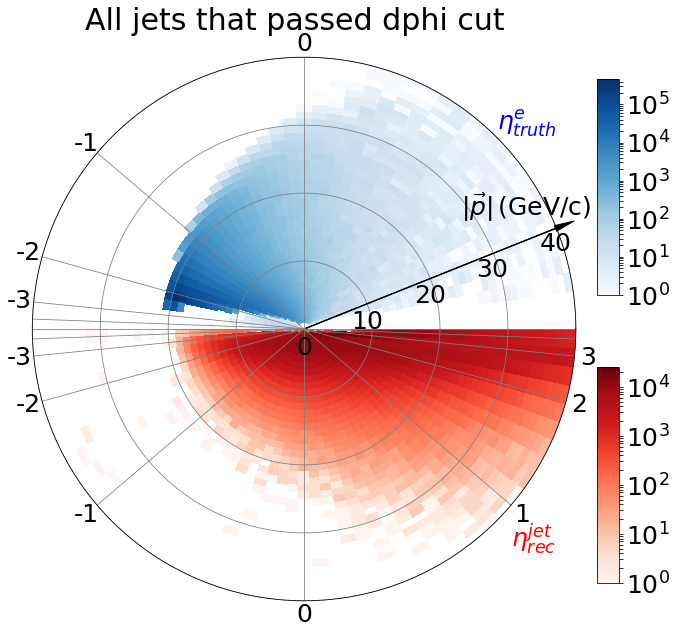

In [19]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['theta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj0_dphi['p'], aj0_dphi['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('All jets that passed dphi cut',fontsize=30, y=0.95)
fig.savefig('images/polar0_dphi.pdf', bbox_inches='tight')

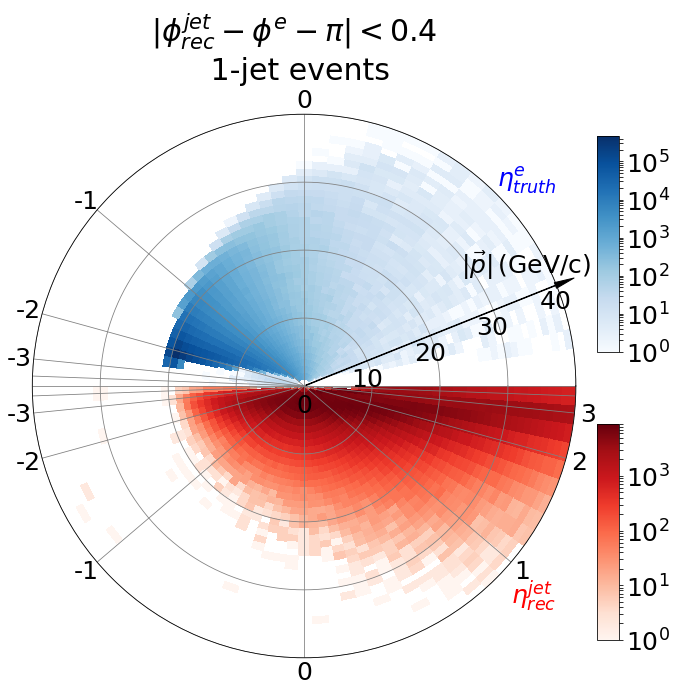

In [20]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['theta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj_dphi_array[1]['p'], aj_dphi_array[1]['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('$|\phi^{jet}_{rec} - \phi^e - \pi| < 0.4$ \n 1-jet events',fontsize=30, y=1.03)
fig.savefig('images/polar1_dphi.pdf', bbox_inches='tight')

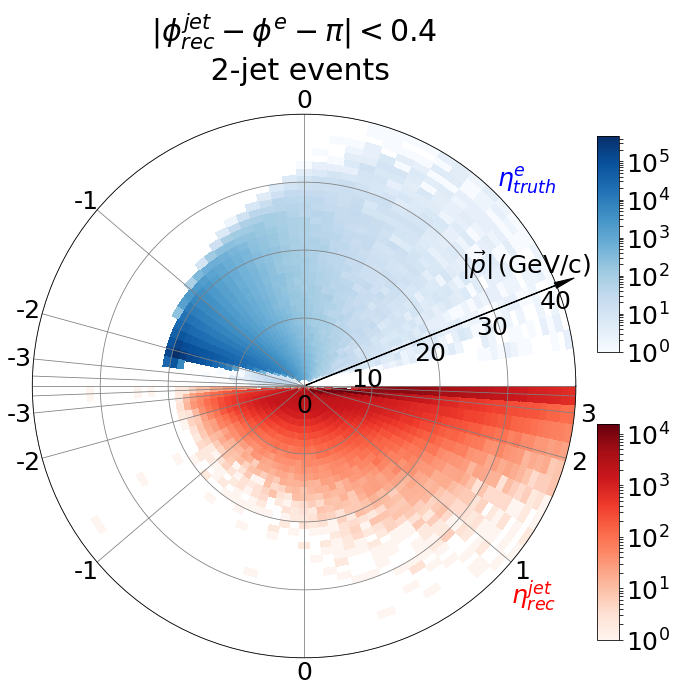

In [21]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['theta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj_dphi_array[2]['p'], aj_dphi_array[2]['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('$|\phi^{jet}_{rec} - \phi^e - \pi| < 0.4$ \n 2-jet events',fontsize=30, y=1.03)
fig.savefig('images/polar2_dphi.pdf', bbox_inches='tight')

In [30]:
a = applyCut(ae0, '10 < electron_truthPt < 30', '10 < electron pT < 30')
b = applyCut(aj0_dphi, '10 < electron_truthPt < 30', '10 < electron pT < 30')

10 < electron pT < 30 182856  fraction kept: 4.7
10 < electron pT < 30 207673  fraction kept: 5.8


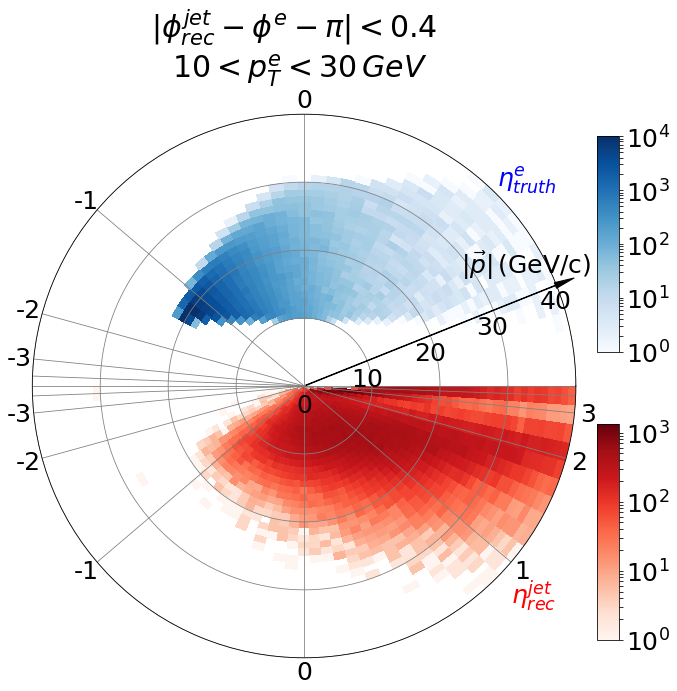

In [33]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(a['electron_truthP'], a['theta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(b['p'], b['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('$|\phi^{jet}_{rec} - \phi^e - \pi| < 0.4$ \n $10 < p_T^e < 30 \, GeV$',fontsize=30, y=1.03)
fig.savefig('images/polar0_dphi_pt.pdf', bbox_inches='tight')

In [34]:
b = applyCut(aj_dphi_array[1], '10 < electron_truthPt < 30', '10 < electron pT < 30')

10 < electron pT < 30 138053  fraction kept: 5.5


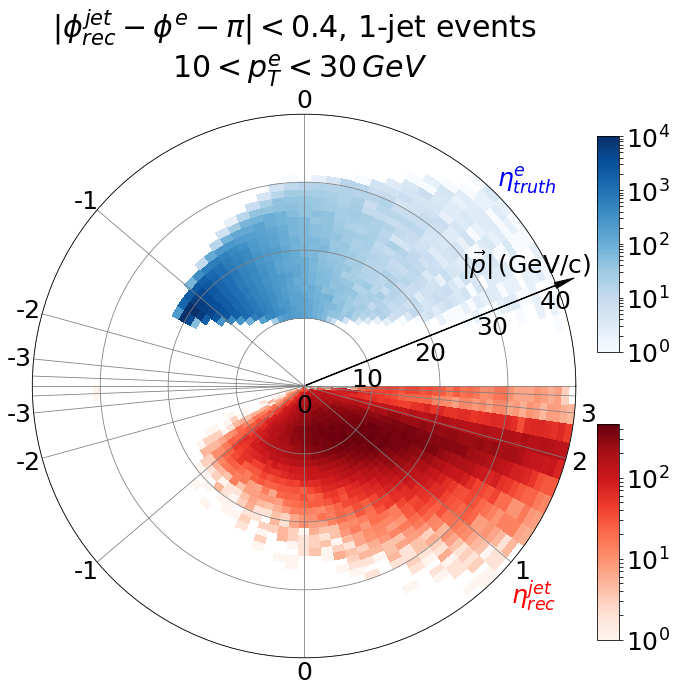

In [35]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(a['electron_truthP'], a['theta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(b['p'], b['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('$|\phi^{jet}_{rec} - \phi^e - \pi| < 0.4$, 1-jet events \n $10 < p_T^e < 30 \, GeV$',fontsize=30, y=1.03)
fig.savefig('images/polar1_dphi_pt.pdf', bbox_inches='tight')